In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
Path_to_weights = '/content/drive/My Drive/NNFL_data/pascal-fcn32s-dag.mat'
PATH_TO_train_txt = '/content/drive/My Drive/NNFL_data/My_model/train.txt'
PATH_TO_train_jpeg = '/content/drive/My Drive/NNFL_data/pascal_data_train_val/Seg_jpeg_train/'
PATH_TO_train_png = '/content/drive/My Drive/NNFL_data/pascal_data_train_val/Seg_png_train/'

In [3]:
import tensorflow as tf
import keras
import numpy as np

from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Input, Add, Dropout, Permute, add, Lambda
import keras.backend as K


from skimage.io import imread, imsave
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import copy
import math

Using TensorFlow backend.


In [0]:
def fcn_base():
    
    FCN_BASE = keras.applications.vgg16.VGG16(include_top=False, input_shape=(512,512,3), weights='imagenet')                                     

    x = Convolution2D(4096,kernel_size=(7,7),padding = "same",activation = "relu",name = "fc_6")(FCN_BASE.output)
    x = Convolution2D(4096,kernel_size=(1,1),padding = "same",activation = "relu",name = "fc_7")(x)

    FCN_BASE = Model(FCN_BASE.input,x)



    weights = np.load(PATH_TO_WEIGHTS)

    fc_6_W = weights['fc6_W'].reshape(7, 7, 512, 4096)
    fc_6_b = weights['fc6_b']
    w = [fc_6_W,fc_6_b]
    FCN_BASE.layers[-2].set_weights(w)


    fc_7_W = weights['fc7_W'].reshape(1, 1, 4096, 4096)
    fc_7_b = weights['fc7_b']
    w = [fc_7_W,fc_7_b]
    FCN_BASE.layers[-1].set_weights(w)

#     for i in FCN_BASE.layers :
#         i.trainable = False

    return FCN_BASE

def fcn_32():
    fcn = fcn_base()
    
    # Apply 1x1 convolution to predict 21 classes of layer 7
    conv7_classes = Convolution2D(21,kernel_size=(1,1),padding="same",activation="relu",name="conv7_classes")(fcn.output)
    
    # 32x bilinear interpolation
    fcn32_out = UpSampling2D(size=(32, 32), interpolation='bilinear',name="fcn32_out")(conv7_classes)    
    return Model(fcn.input,fcn32_out)
    

In [0]:
#FCN_32 = fcn_32()

In [0]:
# x = Lambda(lambda x: K.expand_dims(K.argmax(x),axis=-1), name='argmax')(FCN_32.output)
# new_model = Model(FCN_32.input,x)
# new_model.summary()

In [0]:
text_file = open(PATH_TO_train_txt, "r")
lines = text_file.read().split('\n')
lines = np.array(lines)
lines = lines[0:-1]
lines.shape, lines[-1], lines[-2]

((1464,), '2011_003255', '2011_003246')

In [0]:
li = lines


x =[]
y=[]

for i in li :
    im = Image.open(PATH_TO_train_jpeg + i +'.jpg') 
    im = im.crop((0,0,319,319)) # WARNING : manual square cropping
    im = im.resize((512,512))
    imarr = np.array(im)#.astype(np.float32)
  # imarr = np.expand_dims(imarr, axis=0)
    
    x.append(imarr)
    
    im = Image.open(PATH_TO_train_png + i +'.png') 
    im = im.crop((0,0,319,319)) # WARNING : manual square cropping
    im = im.resize((512,512))
    imarr = np.array(im)#.astype(np.float32)
    imarr = np.expand_dims(imarr, axis=-1)
    
    y.append(imarr)

x_train = np.array(x)
y_train = np.array(y)

x_train.shape, y_train.shape

((1464, 512, 512, 3), (1464, 512, 512, 1))

In [0]:
# def my_loss(y_true,y_pred) :
#     y_pred1 = K.softmax(y_pred, axis=-1)#[0,:,:]
#     y_pred1 = K.cast(y_pred1, K.floatx())
#     return keras.losses.categorical_crossentropy(y_true, y_pred1)
  


In [0]:
kmodel = fcn_32()
kmodel.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0   

In [0]:
# from keras.optimizers import SGD
# opt = SGD(lr=0.00001)

#kmodel.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [0]:
# li  = []
# for i in y_train :
#     li.append(i.reshape((512,512)))

In [0]:
# li = np.array(li)
# li.shape

# y_train2 = li

In [0]:
from keras.optimizers import Adam
opt = Adam(lr=0.00001)

# from keras.optimizers import SGD
# opt = SGD(lr=0.00001)

kmodel.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [0]:
kmodel.fit(x=x_train, y=y_train, batch_size=1,epochs=100,validation_split=0.1)
#kmodel.save('/content/drive/My Drive/NNFL_data/fcn_32_1.h5')

Train on 1317 samples, validate on 147 samples
Epoch 1/100
1317/1317 [==============================] - 1013s 769ms/step - loss: nan - sparse_categorical_accuracy: 0.6723 - val_loss: nan - val_sparse_categorical_accuracy: 0.6163
Epoch 2/100
1317/1317 [==============================] - 1011s 767ms/step - loss: nan - sparse_categorical_accuracy: 0.6737 - val_loss: nan - val_sparse_categorical_accuracy: 0.6163
Epoch 3/100
1317/1317 [==============================] - 1015s 770ms/step - loss: nan - sparse_categorical_accuracy: 0.6737 - val_loss: nan - val_sparse_categorical_accuracy: 0.6163
Epoch 4/100
1317/1317 [==============================] - 1006s 764ms/step - loss: nan - sparse_categorical_accuracy: 0.6737 - val_loss: nan - val_sparse_categorical_accuracy: 0.6163
Epoch 5/100
1317/1317 [==============================] - 1011s 768ms/step - loss: nan - sparse_categorical_accuracy: 0.6737 - val_loss: nan - val_sparse_categorical_accuracy: 0.6163
Epoch 6/100
1317/1317 [====================

KeyboardInterrupt: ignored

In [0]:
#kmodel.save('/content/drive/My Drive/NNFL_data/fcn_32_1.h5')

In [0]:
#kmodel.fit(x=x_train, y=y_train, batch_size=23, epochs=100)

In [0]:
im = Image.open(PATH_TO_train_jpeg+li[13]+'.jpg') 
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((512,512))
imarr = np.array(im)
imarr = np.expand_dims(imarr, axis=0)
pred =  kmodel.predict(imarr)

UFuncTypeError: ignored

In [0]:
pred.shape

(1, 512, 512, 21)

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


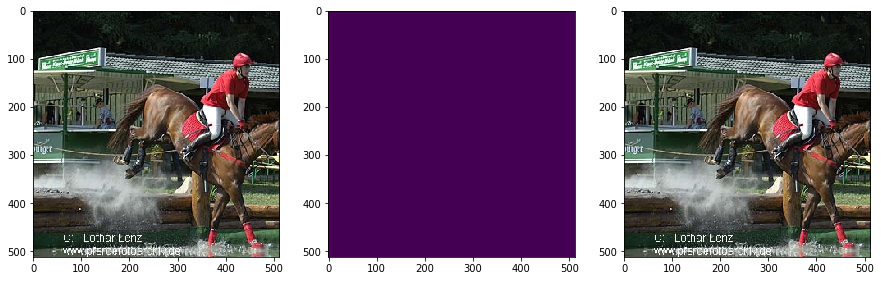

In [0]:
imclass = np.argmax(pred, axis=3)[0,:,:]
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )



In [0]:
np.unique(imclass)

array([ 0,  1,  9, 10, 16, 19])

In [0]:
#np.savetxt("/content/drive/My Drive/NNFL_data/pred_png.csv", imclass, delimiter=",")


array([  0,  13,  15, 255], dtype=uint8)

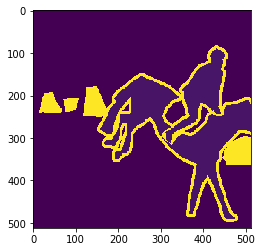

In [0]:
im2 = Image.open(PATH_TO_train_png+li[13]+'.png') 
im2 = im2.crop((0,0,319,319)) # WARNING : manual square cropping
im2 = im2.resize((512,512))
imarr2 = np.array(im2)
plt.imshow( imarr2 )

np.unique(imarr2)

#np.savetxt("/content/drive/My Drive/NNFL_data/array_png.csv", imarr, delimiter=",")


In [0]:
# text_file = open("/Users/Aman/Desktop/pascal_voc_data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt", "r")
# lines = text_file.read().split('\n')
# train_list = np.array(lines)
# print(train_list[0:10])
# len(train_list)

In [0]:
# import shutil


# for i in train_list :
#     #print(i)
#     src = '/Users/Aman/Desktop/pascal_voc_data/VOCdevkit/VOC2012/JPEGImages/' + i +'.jpg'
#     dst = '/Users/Aman/Desktop/pascal_voc_data/VOCdevkit/VOC2012/Seg_jpeg'
#     newPath = shutil.copy(src, dst)
#     #copyfile(src, dst)
    
#    # print(src,dst)